## Import Data Exploration Tools

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.stats as stats

In [15]:
df = pd.read_csv('cancer_reg.csv', encoding='latin-1')

#### Taking a look at the data initially, I can see the following types of data are being provided to predict death rate.
- Incidence and Death Rates (aggregate and per capita)
- Economic Data (income, poverty, etc.)
- Age and Household Data
- Education Data
- Employment Data
- Health Coverage Data
- Race and other Demographic Data

In [16]:
df.head().transpose()

,0,1,2,3,4
avgAnnCount,1397.0,173.0,102.0,427.0,57.0
avgDeathsPerYear,469,70,50,202,26
TARGET_deathRate,164.9,161.3,174.7,194.8,144.4
incidenceRate,489.8,411.6,349.7,430.4,350.1
medIncome,61898,48127,49348,44243,49955
popEst2015,260131,43269,21026,75882,10321
povertyPercent,11.2,18.6,14.6,17.1,12.5
studyPerCap,499.748204,23.111234,47.560164,342.637253,0.0
binnedInc,"(61494.5, 125635]","(48021.6, 51046.4]","(48021.6, 51046.4]","(42724.4, 45201]","(48021.6, 51046.4]"
MedianAge,39.3,33.0,45.0,42.8,48.3


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3047 entries, 0 to 3046
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avgAnnCount              3047 non-null   float64
 1   avgDeathsPerYear         3047 non-null   int64  
 2   TARGET_deathRate         3047 non-null   float64
 3   incidenceRate            3047 non-null   float64
 4   medIncome                3047 non-null   int64  
 5   popEst2015               3047 non-null   int64  
 6   povertyPercent           3047 non-null   float64
 7   studyPerCap              3047 non-null   float64
 8   binnedInc                3047 non-null   object 
 9   MedianAge                3047 non-null   float64
 10  MedianAgeMale            3047 non-null   float64
 11  MedianAgeFemale          3047 non-null   float64
 12  Geography                3047 non-null   object 
 13  AvgHouseholdSize         3047 non-null   float64
 14  PercentMarried          

## Review Non-Numerical Data Types
When performing a regression analysis, all independent variables of interest need to be in numnerical format.  

In this dataset there are only 2 fields that are not numerical. `binnedInc` and `Geography`.  `Geography` is the actual name of the county and therefore will not be useful in a regression.  `binnedInc` essentially contains a less granular description of Median Income.  In this case, neither one of these 2 fields will add to the predictive value of the algorithm, therefore we can just eliminate these columns.  

Note:  If there were non-numerical fields in our dataset that could contribute to the predictive value of the algorithm, there are transformations that we can do to that data to allow them to be used in the algorithm.

In [18]:
df = df.drop(['Geography', 'binnedInc'], axis=1)

## Review Missing Data

Running the algorithm will require all independent variables of interest to have a numerical value.  Not all datasets are 100% complete, thus resulting in missing data on some fields.  Generally, you have 2 options when you have missing data.  

1. Eliminate entries with missing data from the dataset
2. Fill in the missing data through imputation

In this dataset it looks like we have 3 columns with missing data. `PctSomeCol18-24`, `PctPrivateCoverageAlone`, and `PctEmployed16_over`. We'll take a look at each column seperately and make decisions about what to do. 

In [19]:
null = df.isnull().sum()/len(df)
null[null>0].sort_values(ascending=False)

PctSomeCol18_24            0.749918
PctPrivateCoverageAlone    0.199869
PctEmployed16_Over         0.049885
dtype: float64

### Determine How to Treat Missing Data - Percent Some College
`PctSomeCol18-24` is missing in almost 75% of rows. However, it would stand to reason that the educational fields for those under 25 added together should equal 100%.  I will first take a look at the sum of the all the under 25 educational fields when there is no missing data. This should come out to 100%.

In [20]:
all_ed = df[df['PctSomeCol18_24'].notnull()]
df_all_education_totals = round((all_ed['PctNoHS18_24'] + all_ed['PctHS18_24'] 
                           + all_ed['PctSomeCol18_24'] + all_ed['PctBachDeg18_24']))

In [21]:
df_all_education_totals.value_counts()

100.0    762
dtype: int64

I can see from the above that the columns add up to 100%.  Now, the natural assumption here would be to just to calculate and fill in the missing values for this column.  However, having independent variables that are highly correlated with each other can also cause problems in running a regression analysis.  In this case, anytime you have more than 1 percentage columns in a a dataset that add up to 100%, you will have multicollinearity issues.  Therefore, I am just going to drop this column from the dataset.

In [22]:
df['PctSomeCol18_24'].fillna(100 - df['PctNoHS18_24'] - df['PctHS18_24'] - df['PctBachDeg18_24'], inplace=True )

### Determine How to Treat Missing Data - Percent Private Coverage Alone
`PctPrivateCoverageAlone` is missing in nearly 20% of rows. It would not be ideal to lose that many rows in what is already a somewhat small dataset.  Since Private Coverage Alone, should be a subset of Private Coverage, it might be helpful to see if that relationship is consistent accross counties.  

In [23]:
all_PC = df[df['PctPrivateCoverageAlone'].notnull()]
all_PC_relationship = all_PC['PctPrivateCoverageAlone'] / all_PC['PctPrivateCoverage']
print(all_PC_relationship.mean())
print(all_PC_relationship.median())

0.7496985249587111
0.7530792536470667


In [24]:
all_PC[['PctPrivateCoverage','PctPrivateCoverageAlone']].corr()

,PctPrivateCoverage,PctPrivateCoverageAlone
PctPrivateCoverage,1.000000,0.933496
PctPrivateCoverageAlone,0.933496,1.000000


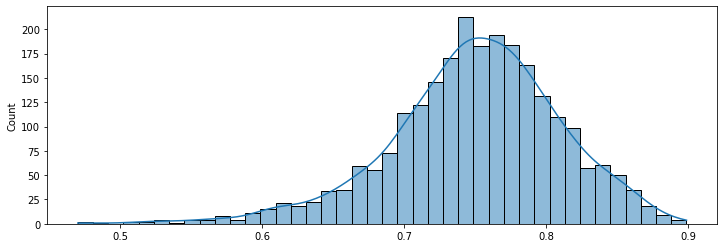

In [25]:
plt.figure(figsize=(12,4))
sns.histplot(all_PC_relationship, kde=True)
plt.show()

There is a very strong correlation between `PctPrivateCoverageAlone` & `PctPrivateCoverage`.  In addition, the distribution of `PctPrivateCoverageAlone` / `PctPrivateCoverage` is pretty highly concentrated around the mean of those values.  Therefore, I think it seems reasonable to fill in null values of `PctPrivateCoverageAlone` with the mean value for (`PctPrivateCoverageAlone` / `PctPrivateCoverage`) * `PctPrivateCoverage`

Note:  With such a strong correlation between these 2 values, we are going to have multicollinearity issues with these fields as well.  For now, I will keep this field in and we will revisit this later.

In [26]:
df['PctPrivateCoverageAlone'].fillna((all_PC_relationship.mean() * df['PctPrivateCoverage']), inplace=True)

### Determine How to Treat Missing Data - Percent Employed 16 and Over
`PctEmployed16_Over` is missing in nearly 5% of rows. Much like the education data, we should be able to calculate the missing data.  `PctEmployed16_Over` + `PctUnemployed16_Over` should equal 100%.  

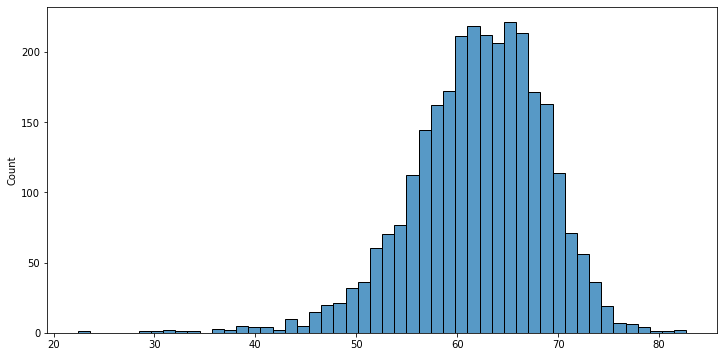

In [27]:
all_emp = df[df['PctEmployed16_Over'].notnull()]
df_all_emp_totals = (all_emp['PctEmployed16_Over'] + all_emp['PctUnemployed16_Over'])

plt.figure(figsize=(12,6))
sns.histplot(df_all_emp_totals)
plt.show()

In [28]:
all_emp[['PctEmployed16_Over','PctUnemployed16_Over']].corr()

,PctEmployed16_Over,PctUnemployed16_Over
PctEmployed16_Over,1.000000,-0.648114
PctUnemployed16_Over,-0.648114,1.000000


In [29]:
df.dropna(axis=0, inplace=True)

Unlike education data, these values for employment do not neatly add up to 100% and the correlations between these values are not strong.  Therefore, we wouldn't be able to calculate the employment rate by looking at unemployment rate.  Since the missing values are less than 5% of the entire dataset, we will simply remove these rows from our dataset.  

# Explore the Data
Now that we have eliminated non-numerical values and addressed any issues related to missing values, it's time to take a closer look at our dataset to see if there is any additional cleaning that is required.  We'll start just by looking at a summary of the data.

In [30]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
avgAnnCount,2895.0,611.237720,1442.306706,6.000000,75.500000,171.000000,515.000000,3.815000e+04
avgDeathsPerYear,2895.0,187.461485,513.453780,3.000000,28.000000,61.000000,148.000000,1.401000e+04
TARGET_deathRate,2895.0,178.638964,27.464991,59.700000,161.300000,178.100000,195.200000,2.939000e+02
incidenceRate,2895.0,447.968130,52.737861,201.300000,420.300000,453.549422,480.500000,1.014200e+03
medIncome,2895.0,47001.894301,12047.178175,22640.000000,38751.000000,45132.000000,52488.000000,1.256350e+05
popEst2015,2895.0,103678.576511,336204.117463,827.000000,11652.500000,26521.000000,68140.500000,1.017029e+07
povertyPercent,2895.0,16.915440,6.425357,3.200000,12.150000,15.900000,20.500000,4.740000e+01
studyPerCap,2895.0,157.692163,541.188736,0.000000,0.000000,0.000000,81.759464,9.762309e+03
MedianAge,2895.0,45.104387,44.495505,22.300000,37.700000,41.000000,44.000000,6.240000e+02
MedianAgeMale,2895.0,39.598135,5.231846,22.400000,36.300000,39.600000,42.600000,6.470000e+01


### Distribution of Dependent Variable
Let's take a look at the distribution of our Target (Dependent Variable).  The distrubution appears to be relatively normally distributed, so we don't need to do anything more at this time.  We will do a more thorough analysis of our regression assumptions and testing for outliers later. 

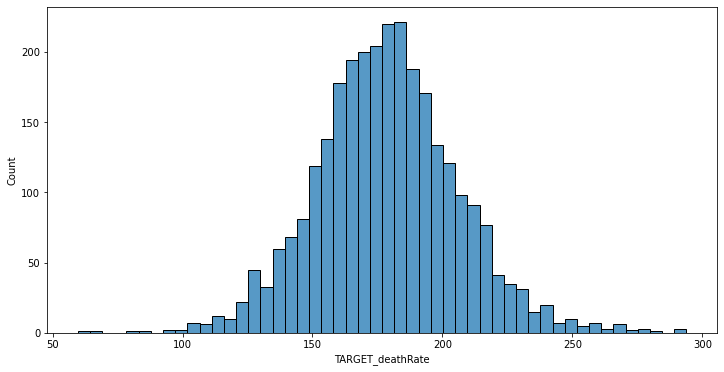

In [31]:
plt.figure(figsize=(12,6))
sns.histplot(x='TARGET_deathRate', data=df, bins=50)
plt.show()

### Identify Relationship Between Independent and Dependent Variables

First I want to see if there is actually a linear relationship between my data and the various predictors. One of the easiest ways to do this it to create a scatterplot of all my independent variables.

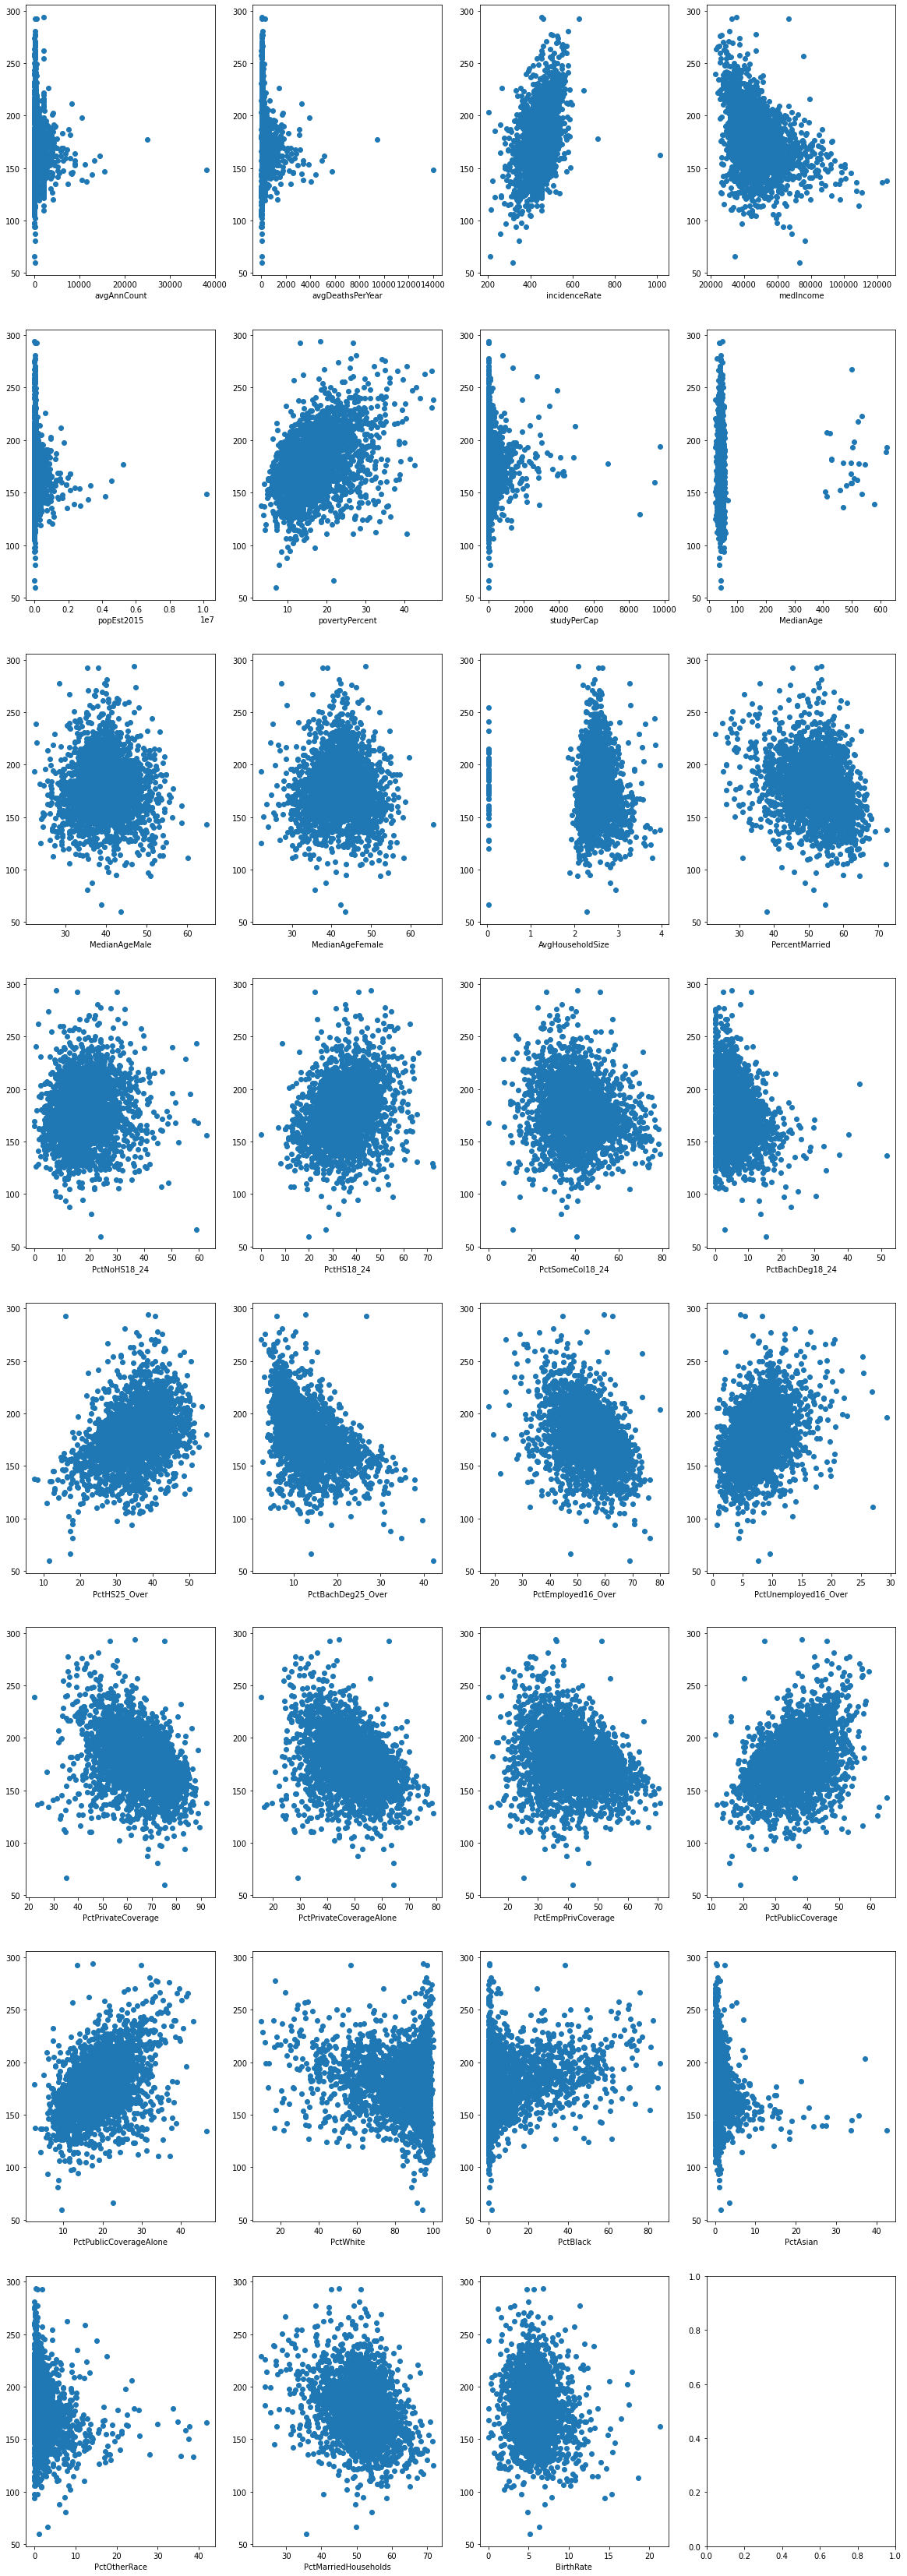

In [32]:
i, j = 0, 0
plots_per_row = 4
fig, axs = plt.subplots(math.ceil(len(df.drop('TARGET_deathRate', axis=1).columns)/plots_per_row),plots_per_row, figsize=(20, 60))

for col in df.drop('TARGET_deathRate', axis=1).columns:
    axs[i][j].scatter(df[col], df['TARGET_deathRate'])
    axs[i][j].set_xlabel(col)
    j += 1
    if j % plots_per_row == 0:
        i += 1
        j = 0
plt.show()

So, it appears we have issues with several pieces of our data.  
- Issue 1: Median Age has values greater than 100, which is impossible
- Issue 2: Average Household Size has values of 0, which is impossible
- Issue 3: Race data data does not seem to have a linear relationship with our dependent variable
- Issue 4: {} Studies Per Capita also do not appear to have a linear relationship with our dependent variable.

### Issue 1: Median Age
We need to see how many data points are incorrect and determine what to do with them.

In [33]:
df_age_over_100 = df[df['MedianAge'] > 100]
len(df_age_over_100)

27

In [34]:
df = df[df['MedianAge'] <= 100]

With only 27 rows having data that seems obviously incorrect, I think it best just to drop all the data.  We'll then take a look again at our Median Age values and see if the data looks cleaner.

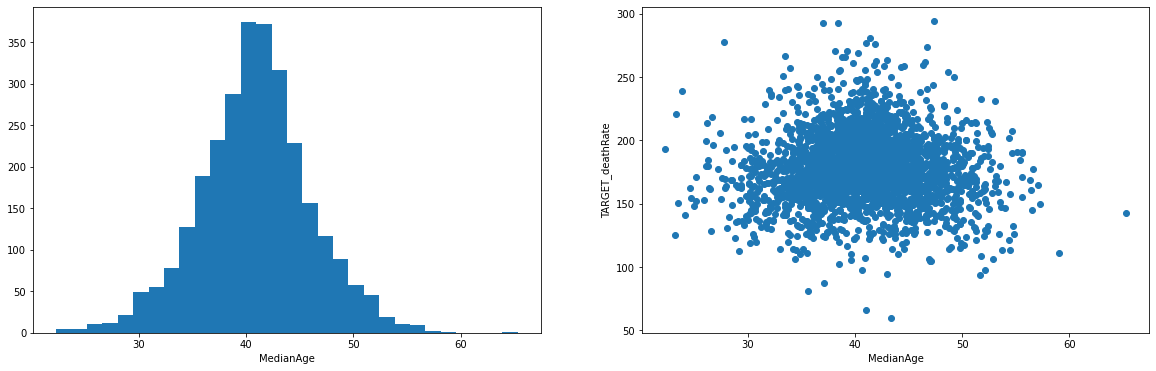

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].hist(df['MedianAge'], bins=30)
axs[0].set_xlabel('MedianAge')
axs[1].scatter(df['MedianAge'], df['TARGET_deathRate'])
axs[1].set_xlabel('MedianAge')
axs[1].set_ylabel('TARGET_deathRate')
plt.show()

### Issue 2:  Average Household Size
We will take a look at household values that are equal to 0 and see whether it is better to fill in the incorrect/missing data or if it is better to remove those rows from our analyis.

In [36]:
num_households_0 = df[df['AvgHouseholdSize'] < 1]
num_households_Not_0 = df[df['AvgHouseholdSize'] >= 1]
len(num_households_0)

57

In [37]:
num_households_Not_0['AvgHouseholdSize'].describe()

count    2811.000000
mean        2.528417
std         0.246909
min         1.860000
25%         2.370000
50%         2.500000
75%         2.640000
max         3.970000
Name: AvgHouseholdSize, dtype: float64

In [38]:
num_households_Not_0[['TARGET_deathRate', 'AvgHouseholdSize']].corr()

,TARGET_deathRate,AvgHouseholdSize
TARGET_deathRate,1.000000,-0.035233
AvgHouseholdSize,-0.035233,1.000000


I think looking at the distribution of the data, it would be reasonable to just to fill in values with the mean.  Or, we can simply drop rows.  57 rows is still pretty small, but given the overall size of our dataset and the low correlation between the household size and our dependent variable, it probably isn't a bad idea to just try and keep as much data as possible. 

In [39]:
AvgHouseMean = num_households_Not_0['AvgHouseholdSize'].mean()
df.loc[:,'AvgHouseholdSize'] = df['AvgHouseholdSize'].where(df.loc[:,'AvgHouseholdSize'] > 1, AvgHouseMean)

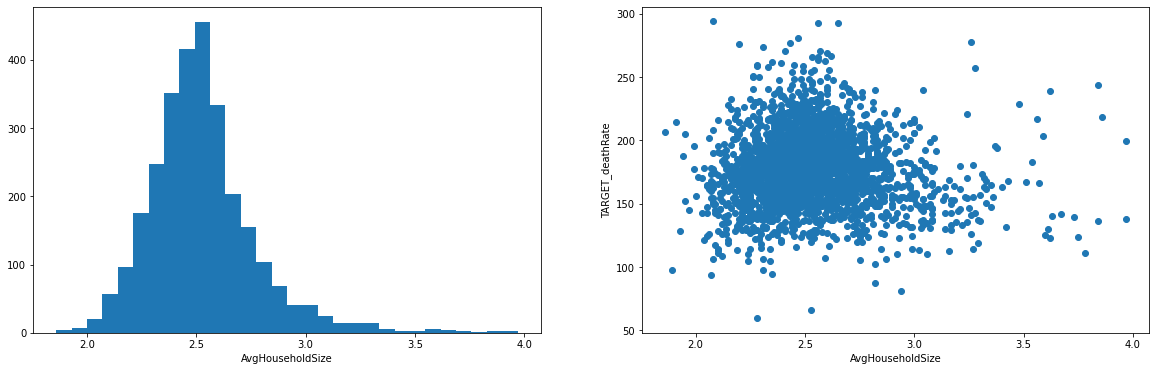

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].hist(df['AvgHouseholdSize'], bins=30)
axs[0].set_xlabel('AvgHouseholdSize')
axs[1].scatter(df['AvgHouseholdSize'], df['TARGET_deathRate'])
axs[1].set_xlabel('AvgHouseholdSize')
axs[1].set_ylabel('TARGET_deathRate')
plt.show()

### Issue 3:  Race Data
The first thing I can try to do to see if we can use these as predictors is to do a non-linear transformation on the data. I'll start first by transforming the fields and then re-analyzing the data.

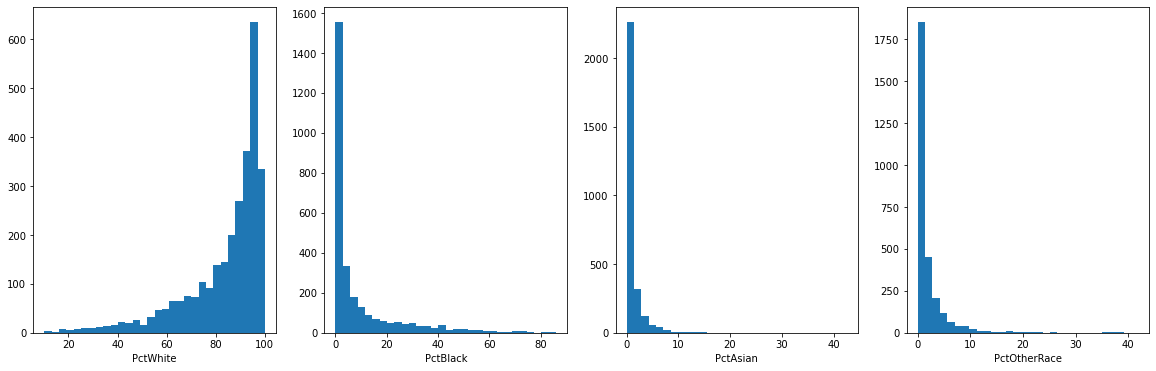

In [41]:
race_data = df[['PctWhite', 'PctBlack', 'PctAsian', 'PctOtherRace']]


j = 0
fig, axs = plt.subplots(1, 4, figsize=(20, 6))
for col in race_data.columns:
    axs[j].hist(df[col], bins=30)
    axs[j].set_xlabel(col)
    j +=1

plt.show()

It that much of the data has a lot of zero values.  The only data that seems to be complete is the `PctWhite`.  So, I think the best result for now will be to create a new category of `PctNonWhite` and just have those 2 descriptive fields.  I'll then do a log transformation of the data in order to see how that improves the linearity of our data. 

In [42]:
df.drop(df[df['PctWhite'] == 100].index, inplace=True)

In [43]:
race_data = pd.DataFrame()
race_data['White'] = df['PctWhite'] * df['popEst2015']
race_data['NonWhite'] = (100 - df['PctWhite']) * df['popEst2015']

race_data = np.log(race_data)

race_data['TARGET_deathRate'] = df['TARGET_deathRate']

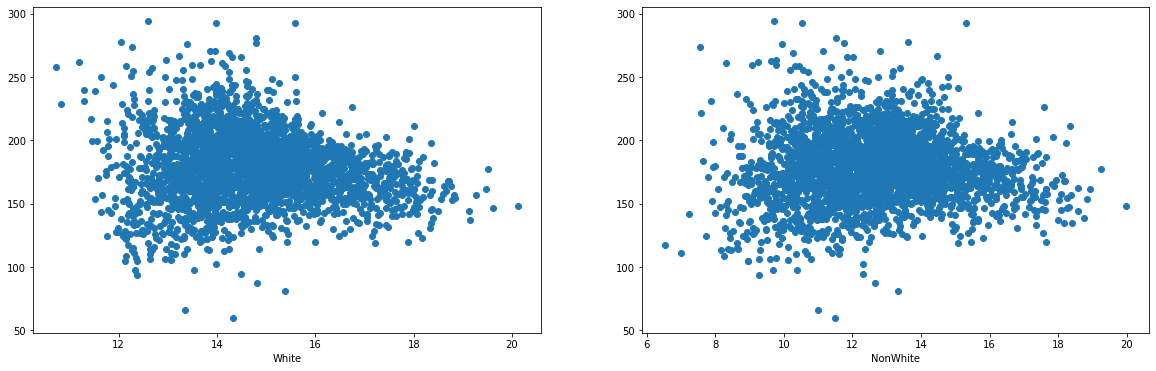

In [44]:
fig, axs = plt.subplots(1,2, figsize=(20,6))
axs[0].scatter(race_data['White'], race_data['TARGET_deathRate'])
axs[0].set_xlabel('White')
axs[1].scatter(race_data['NonWhite'], race_data['TARGET_deathRate'])
axs[1].set_xlabel('NonWhite')
plt.show()

In [45]:
df = pd.concat([df, race_data.drop('TARGET_deathRate', axis=1)], axis=1)
df.drop(['PctWhite', 'PctAsian', 'PctBlack', 'PctOtherRace'], axis=1, inplace=True)

In [46]:
len(df[df['studyPerCap'] == 0])/len(df)

0.6351587024764562

In [47]:
df[['studyPerCap','TARGET_deathRate']].corr()

,studyPerCap,TARGET_deathRate
studyPerCap,1.000000,-0.020677
TARGET_deathRate,-0.020677,1.000000


In [48]:
df.drop(df[['avgAnnCount', 'avgDeathsPerYear', 'popEst2015', 'studyPerCap']], axis=1, inplace=True)

Now that we have dealt with all our issues, lets take a look at those scatterplots once again.  

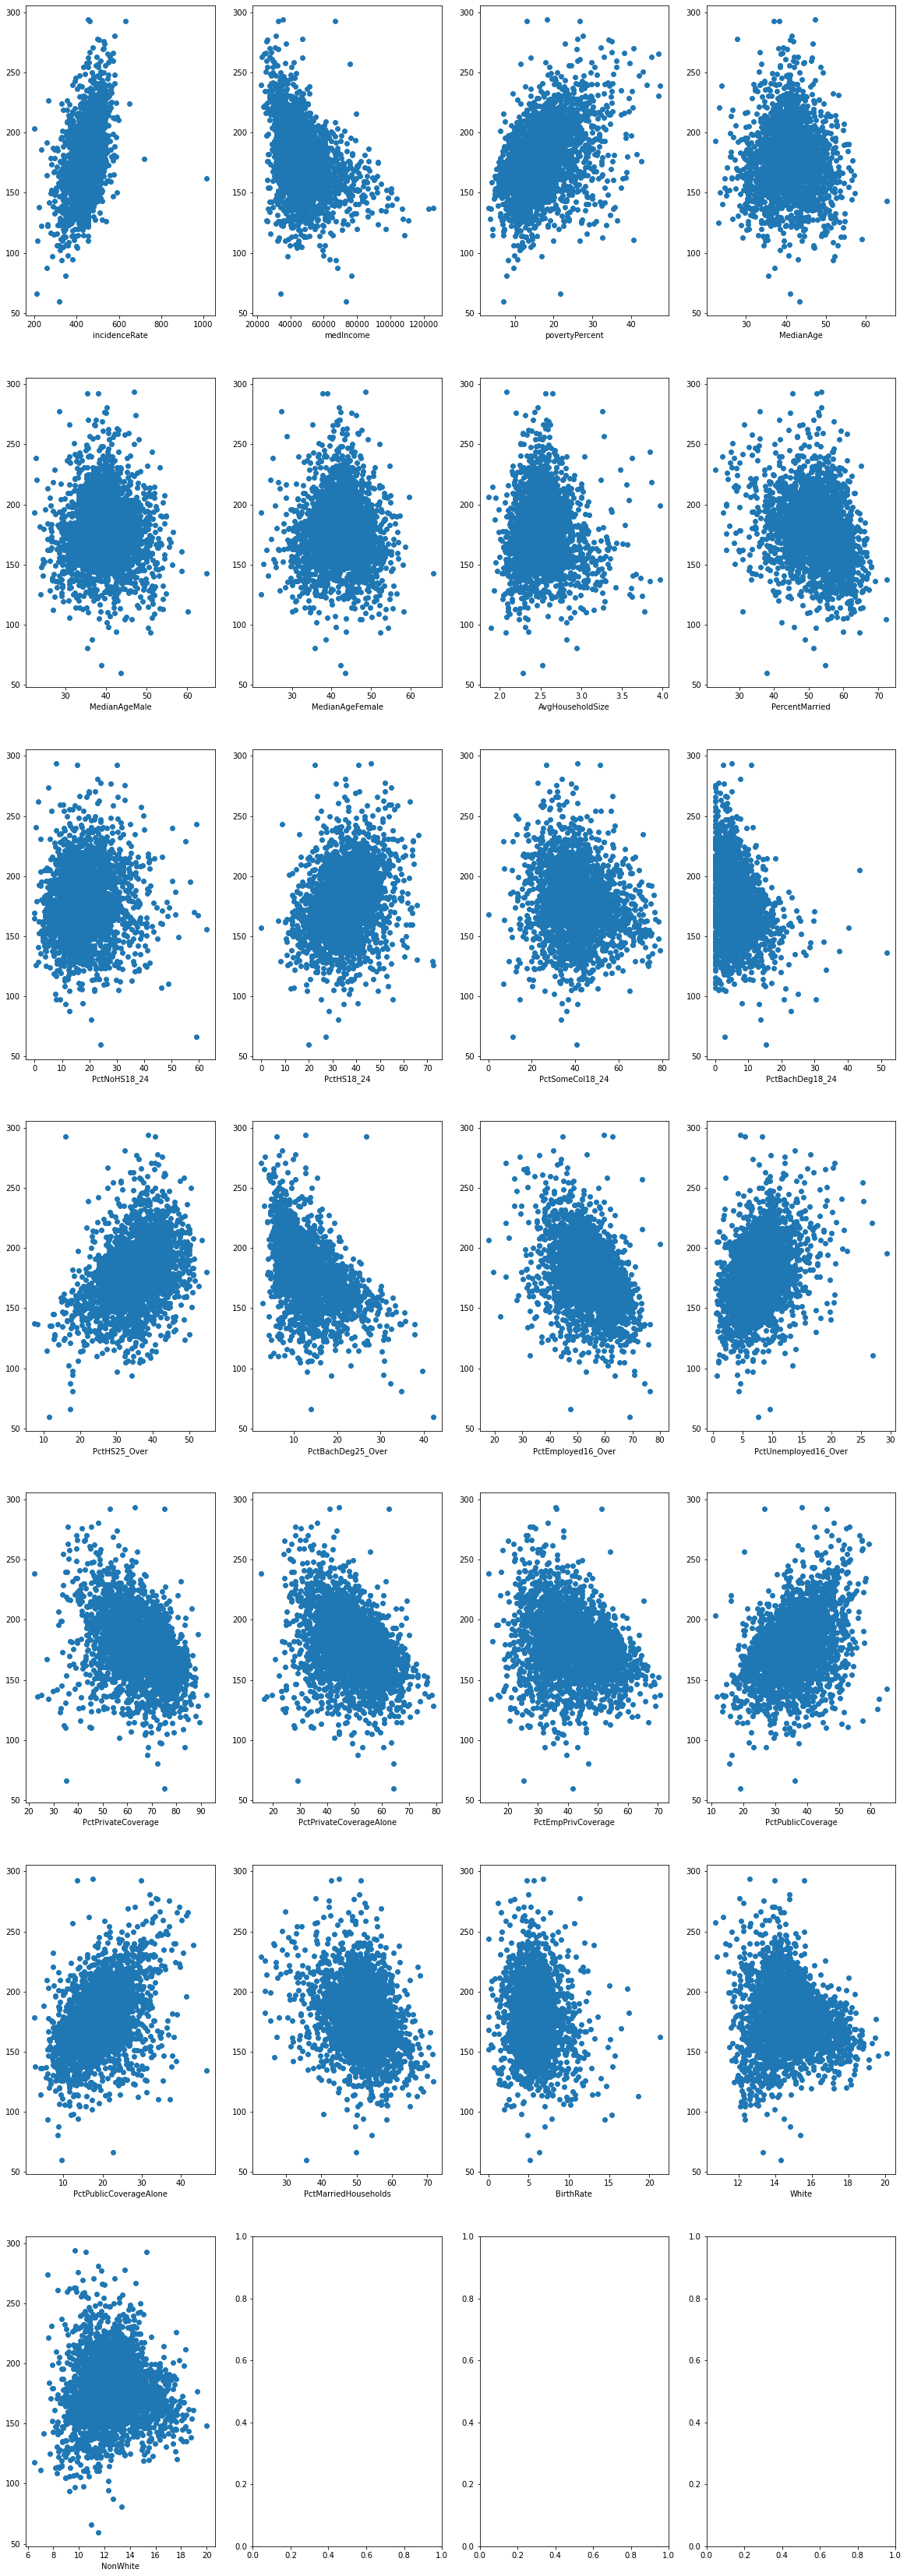

In [49]:
i, j = 0, 0
plots_per_row = 4
fig, axs = plt.subplots(math.ceil(len(df.drop('TARGET_deathRate',axis=1).columns)/plots_per_row),plots_per_row, figsize=(20, 60))

for col in df.drop('TARGET_deathRate',axis=1).columns:
    axs[i][j].scatter(df[col], df['TARGET_deathRate'])
    axs[i][j].set_xlabel(col)
    j += 1
    if j % plots_per_row == 0:
        i += 1
        j = 0
plt.show()

Those plots generally look a lot better.  It is not always easy to see a direct linear relationship between the independent and dependent variable, but we will work on addressing some if these issues later.  Finally, it is also worth looking at distribution plots of all our independent variables.

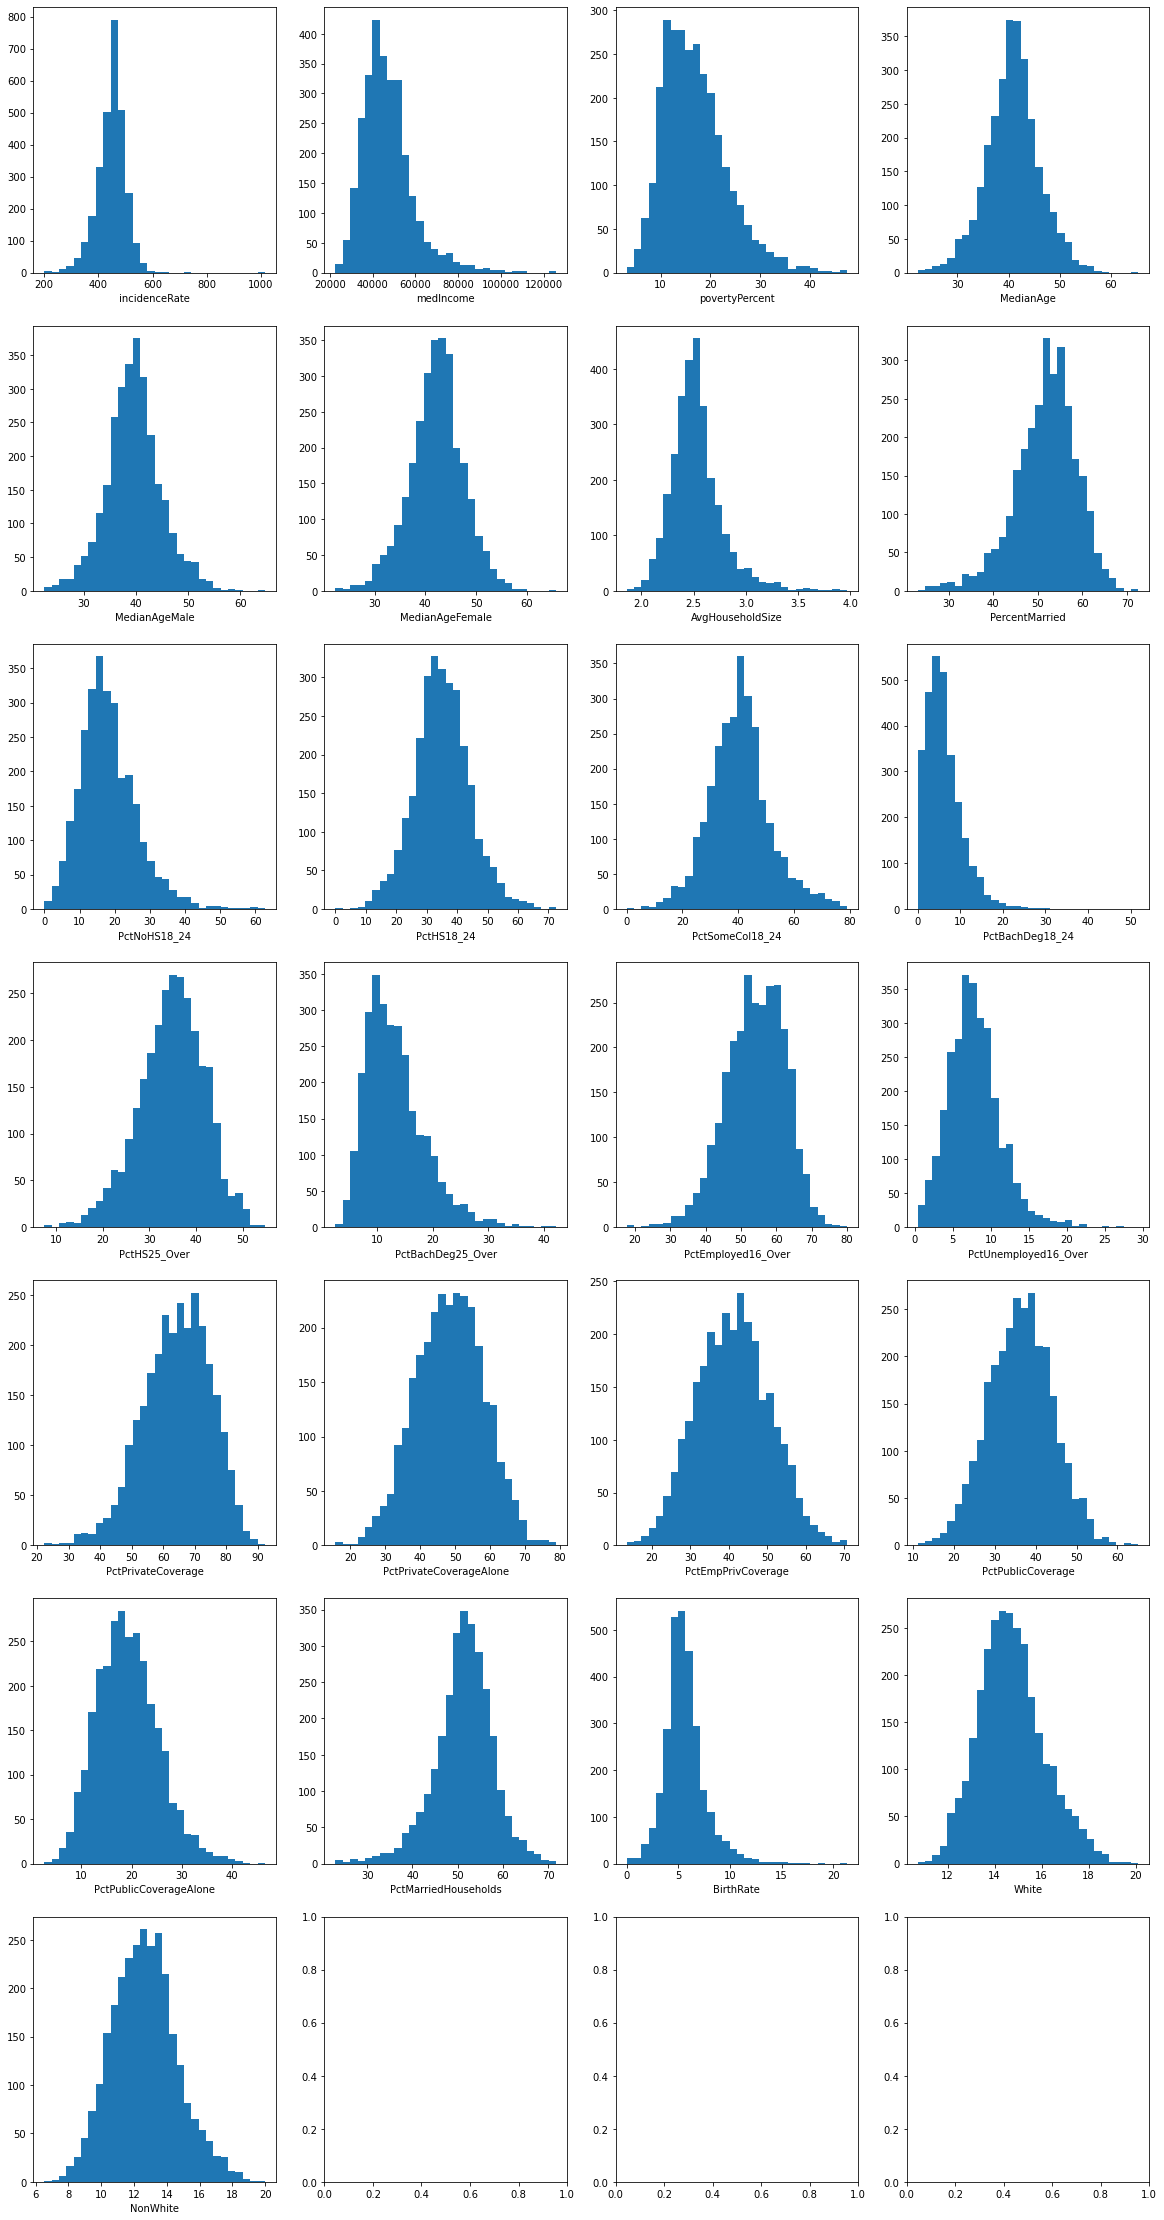

In [50]:
i, j = 0, 0
plots_per_row = 4
fig, axs = plt.subplots(math.ceil(len(df.drop('TARGET_deathRate',axis=1).columns)/plots_per_row),plots_per_row, figsize=(20, 40))

for col in df.drop('TARGET_deathRate',axis=1).columns:
    axs[i][j].hist(df[col], bins=30)
    axs[i][j].set_xlabel(col)
    j += 1
    if j % plots_per_row == 0:
        i += 1
        j = 0
plt.show()

Based on these distributions I see that there might be some large outliers in Incidence Rate.  So, let's go ahead and take a look at Incidence Rate now.

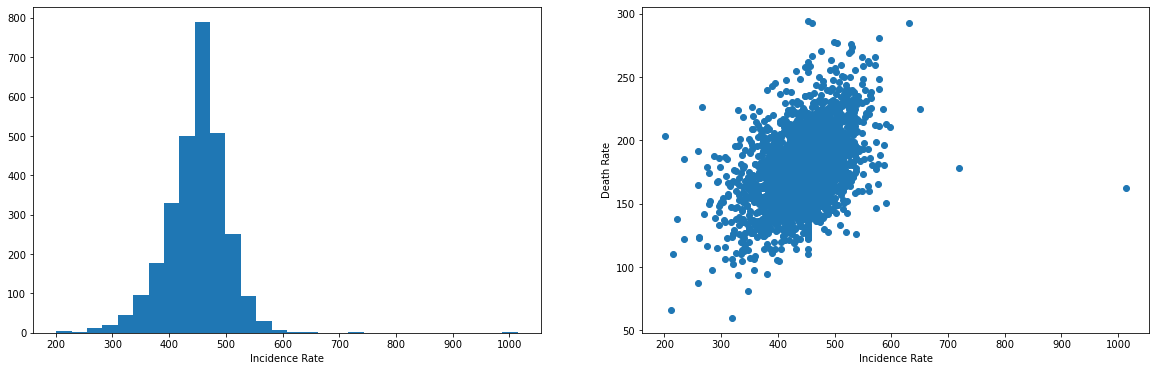

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].hist(df['incidenceRate'], bins=30)
axs[0].set_xlabel('Incidence Rate')
axs[1].scatter(df['incidenceRate'], df['TARGET_deathRate'])
axs[1].set_xlabel('Incidence Rate')
axs[1].set_ylabel('Death Rate')
plt.show()

It does seem like there are a few outliers here. I'll go ahead and remove rows with values above 700.

In [56]:
df = df[df['incidenceRate']<700]

## Export the Cleaned Data
I'll export the csv file for use in the next stage of our analysis.

In [59]:
df.to_csv('cancer_reg_cleaned.csv')